In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

import time
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches

# Finding a concise rule for SITP Fraud

## Data read and exploration

##### Looking at how the data looks

In [2]:
df = pd.read_csv('SITP_data2.csv')

df.head()

,vtc_datecreated,dt,tm,vtc_accountid,vtc_type,vtc_subtype,vtc_subcategory,vtc_description,amountrm,vtm_accountid,vtm_outletid,correlationid,referenceid,Class
0,2021-07-07 21:06:43.000 +0800,7/7/2021,21:06:43,5c5a7c6ee11823000746b643,DYNAMIC,SETEL_VENTURES_SDN_BHD,DEEPLINK,Paid SETEL,25,5eeb3e7eb0bb9b0001344564,MCM0094234,91513068-d092-43ff-8695-f887732cee2f,60e5365c44683804136c0f55,0
1,2021-07-07 21:06:43.000 +0800,7/7/2021,21:06:43,5c5a7c6ee11823000746b643,DYNAMIC,SETEL_VENTURES_SDN_BHD,DEEPLINK,Paid SETEL,25,5eeb3e7eb0bb9b0001344564,MCM0094234,91513068-d092-43ff-8695-f887732cee2f,60e5365c44683804136c0f55,0
2,2021-07-07 21:06:43.000 +0800,7/7/2021,21:06:43,5c5a7c6ee11823000746b643,DYNAMIC,SETEL_VENTURES_SDN_BHD,DEEPLINK,Paid SETEL,25,5eeb3e7eb0bb9b0001344564,MCM0094234,91513068-d092-43ff-8695-f887732cee2f,60e5365c44683804136c0f55,0
3,2021-07-07 21:06:43.000 +0800,7/7/2021,21:06:43,5c5a7c6ee11823000746b643,DYNAMIC,SETEL_VENTURES_SDN_BHD,DEEPLINK,Paid SETEL,25,5eeb3e7eb0bb9b0001344564,MCM0094234,91513068-d092-43ff-8695-f887732cee2f,60e5365c44683804136c0f55,0
4,2021-06-08 22:51:10.000 +0800,8/6/2021,22:51:10,5d1c3f49daf2e800018b1452,DYNAMIC,MOLPAY_SDN_BHD-1,ONLINE,Paid QSR STORES SDN BHD,41,5f1818182b43a0000166ab99,RazerMS_kfcdeliverymbb,3c7fdac7-c19f-4478-a730-26b19dc4ce29,60bf135edf4df1179e81f901,0


In [3]:
df.describe()

,amountrm,Class
count,10013.000000,10013.000000
mean,50.870269,0.405872
std,75.771291,0.491085
min,0.000000,0.000000
25%,10.000000,0.000000
50%,29.000000,0.000000
75%,51.000000,1.000000
max,900.000000,1.000000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10013 entries, 0 to 10012
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   vtc_datecreated  10013 non-null  object
 1   dt               10013 non-null  object
 2   tm               10013 non-null  object
 3   vtc_accountid    10013 non-null  object
 4   vtc_type         10013 non-null  object
 5   vtc_subtype      10013 non-null  object
 6   vtc_subcategory  10013 non-null  object
 7   vtc_description  10013 non-null  object
 8   amountrm         10013 non-null  int64 
 9   vtm_accountid    10013 non-null  object
 10  vtm_outletid     4945 non-null   object
 11  correlationid    10013 non-null  object
 12  referenceid      10013 non-null  object
 13  Class            10013 non-null  int64 
dtypes: int64(2), object(12)
memory usage: 1.1+ MB


- The date column here is not yet a date
- but *dt* and *tm* is already there, need to convert these into dates and time

*Converting into time first*

In [5]:
df['Time'] = df['tm'] = df['dt'] + " " + df['tm']
df['Time'] = pd.to_datetime(df['Time'], format='%d/%m/%Y %H:%M:%S')

df['unix'] = (df['Time'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

In [6]:
df.isnull().sum().max()

5068

In [7]:
df.columns

Index(['vtc_datecreated', 'dt', 'tm', 'vtc_accountid', 'vtc_type',
       'vtc_subtype', 'vtc_subcategory', 'vtc_description', 'amountrm',
       'vtm_accountid', 'vtm_outletid', 'correlationid', 'referenceid',
       'Class', 'Time', 'unix'],
      dtype='object')

## Seeing the fraud distribution

In [8]:
# Out of the lazada payments, its not that skewed, so this should be good
print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

No Frauds 59.41 % of the dataset
Frauds 40.59 % of the dataset


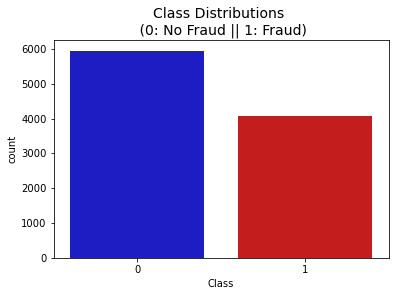

In [9]:
colors = ["#0101DF", "#DF0101"]

sns.countplot('Class', data=df, palette=colors)
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)
plt.show()

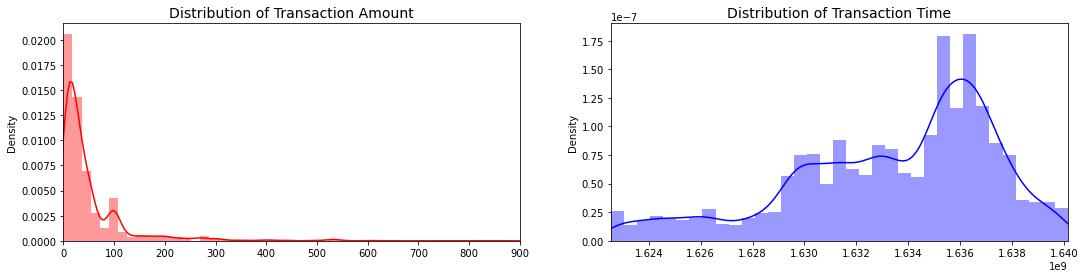

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

amount_val = df['amountrm'].values
time_val = df['unix'].values

sns.distplot(amount_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(time_val, ax=ax[1], color='b')
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])



plt.show()

## Encoding categorical variables into numeric

- type
- subtype
- subcategory
- vtm_accountid


Here we are going to use to methods, label encoder and one hot encoding
- there will be 2 dfs 
- then each will be trained similarly and see whichever is easier to do
- all the categories listed above will have the encoder

### Label Encoder

In [11]:
from sklearn.preprocessing import LabelEncoder

In [12]:
#creating an empty df
le_df = pd.DataFrame()

#calling an instance of Label Encoder
labelencoder = LabelEncoder()

# Assigning numerical values and storing in another column
le_df['unix'] = df['unix']
le_df['amtrm'] = df['amountrm']
le_df['type_cat'] = labelencoder.fit_transform(df['vtc_type'])
le_df['subtype_cat'] = labelencoder.fit_transform(df['vtc_subtype'])
le_df['subcat_cat'] = labelencoder.fit_transform(df['vtc_subcategory'])
le_df['accountid_cat'] = labelencoder.fit_transform(df['vtm_accountid'])
le_df['class'] = labelencoder.fit_transform(df['Class'])

In [13]:
df.columns

Index(['vtc_datecreated', 'dt', 'tm', 'vtc_accountid', 'vtc_type',
       'vtc_subtype', 'vtc_subcategory', 'vtc_description', 'amountrm',
       'vtm_accountid', 'vtm_outletid', 'correlationid', 'referenceid',
       'Class', 'Time', 'unix'],
      dtype='object')

In [14]:
le_df.head()

,unix,amtrm,type_cat,subtype_cat,subcat_cat,accountid_cat,class
0,1625692003,25,2,25,0,20,0
1,1625692003,25,2,25,0,20,0
2,1625692003,25,2,25,0,20,0
3,1625692003,25,2,25,0,20,0
4,1623192670,41,2,17,1,24,0


In [15]:
le_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10013 entries, 0 to 10012
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   unix           10013 non-null  int64
 1   amtrm          10013 non-null  int64
 2   type_cat       10013 non-null  int32
 3   subtype_cat    10013 non-null  int32
 4   subcat_cat     10013 non-null  int32
 5   accountid_cat  10013 non-null  int32
 6   class          10013 non-null  int64
dtypes: int32(4), int64(3)
memory usage: 391.3 KB


In [16]:
le_df.describe()

,unix,amtrm,type_cat,subtype_cat,subcat_cat,accountid_cat,class
count,1.001300e+04,10013.000000,10013.00000,10013.000000,10013.000000,10013.000000,10013.000000
mean,1.633411e+09,50.870269,1.49965,8.375012,1.274144,28.009687,0.405872
std,3.972312e+06,75.771291,0.50162,8.454366,0.806144,9.569113,0.491085
min,1.622548e+09,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,1.630908e+09,10.000000,1.00000,1.000000,1.000000,29.000000,0.000000
50%,1.634465e+09,29.000000,2.00000,1.000000,1.000000,31.000000,0.000000
75%,1.636398e+09,51.000000,2.00000,18.000000,2.000000,31.000000,1.000000
max,1.640151e+09,900.000000,2.00000,27.000000,2.000000,43.000000,1.000000


### One hot Encoder

In [17]:
from sklearn.preprocessing import OneHotEncoder

In [18]:
#creating another instance of main DF
enc_df = df

# generate binary values using get_dummies
#also merge into the main encoder df
dum_df = pd.get_dummies(enc_df, columns=["vtc_type"], prefix=["Type_"] )
enc_df = enc_df.merge(dum_df)

dum_df = pd.get_dummies(df, columns=["vtc_subtype"], prefix=["subtype_"] )
enc_df = enc_df.merge(dum_df)

dum_df = pd.get_dummies(df, columns=["vtc_subcategory"], prefix=["subcategory_is"] )
enc_df = enc_df.merge(dum_df)

dum_df = pd.get_dummies(df, columns=["vtm_accountid"], prefix=["accountid_is"] )
enc_df = enc_df.merge(dum_df)


In [19]:
enc_df = enc_df.drop(columns=['vtc_datecreated', 'dt', 'tm', 'vtc_accountid', 'vtc_type', 'vtc_subtype', 'vtc_subcategory', 'vtc_description', 'vtm_accountid', 'vtm_outletid', 'correlationid', 'referenceid', 'Time'])

In [20]:
#print(df.columns)
print(enc_df.columns)

Index(['amountrm', 'Class', 'unix', 'Type__ALIPAY CONNECT PTE. LTD.',
       'Type__ALIPAY MALAYSIA', 'Type__DYNAMIC',
       'subtype__2C2P_SYSTEM_(M)_SDN_BHD', 'subtype__ALICONNECT',
       'subtype__AMANAH_SAHAM_NASIONAL_BERHAD', 'subtype__APIGATE_SDN_BHD',
       'subtype__ASIAPAY_(M)_SDN_BHD', 'subtype__CELCOM_MOBILE_SDN_BHD',
       'subtype__FAVE_ASIA_TECHNOLOGIES_SDN_BHD',
       'subtype__GAM_TONG_(HONG_KONG_RECIPE)_HOLDING_SDN_BHD',
       'subtype__GHL_EPAYMENTS_SDN_BHD', 'subtype__GHL_EPAYMENTS_SDN_BHD-1',
       'subtype__HELLOGOLD_SDN_BHD', 'subtype__IPAY88_(M)_SDN_BHD',
       'subtype__IPAY88_(M)_SDN_BHD-1', 'subtype__IPAY88_(M)_SDN_BHD-2',
       'subtype__JOMRUN_SDN._BHD.', 'subtype__MAXIS_BROADBAND_SDN_BHD',
       'subtype__MOLPAY_SDN_BHD', 'subtype__MOLPAY_SDN_BHD-1',
       'subtype__MOLPAY_SDN_BHD-2', 'subtype__MOREFUN_MOBILE_APP_SDN_BHD',
       'subtype__PRESTO_MALL_SDN_BHD', 'subtype__REVENUE_MONSTER_SDN_BHD',
       'subtype__REVENUE_MONSTER_SDN_BHD-1',
     

## Scaling the Data

In [21]:
from sklearn.preprocessing import StandardScaler, RobustScaler

In [22]:
#creating an instance
#std_scaler = StandarScaler()
rob_scaler = RobustScaler() #only using this bcs less prone to outliers

enc_df['scaled_amount'] = rob_scaler.fit_transform(enc_df['amountrm'].values.reshape(-1,1))
enc_df['scaled_time'] = rob_scaler.fit_transform(enc_df['unix'].values.reshape(-1,1))

enc_df.drop(['amountrm', 'unix'], axis=1, inplace=True)

In [23]:
#to put the values in front
scaled_amount = enc_df['scaled_amount']
scaled_time = enc_df['scaled_time']

enc_df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
enc_df.insert(0, 'scaled_amount', scaled_amount)
enc_df.insert(1, 'scaled_time', scaled_time)

enc_df.head()

,scaled_amount,scaled_time,Class,Type__ALIPAY CONNECT PTE. LTD.,Type__ALIPAY MALAYSIA,Type__DYNAMIC,subtype__2C2P_SYSTEM_(M)_SDN_BHD,subtype__ALICONNECT,subtype__AMANAH_SAHAM_NASIONAL_BERHAD,subtype__APIGATE_SDN_BHD,...,accountid_is_5f5f74d330f49c0001803c20,accountid_is_5f8ff9ac27956500014d08f5,accountid_is_5fa51fa0a77bb70001a86b13,accountid_is_5fbb3664ffc4e60001ffebb2,accountid_is_5fbdba2421b6210001486155,accountid_is_5fcf54722d60840001a51e6e,accountid_is_5fd2b261a2b499000110a2de,accountid_is_602224c2911de623ee9bd8db,accountid_is_606c070f54030165a77ccc66,accountid_is_60c9cb356f8fac4e7f22ec13
0,0.025,-1.889678,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.025,-1.889678,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.025,-1.889678,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.025,-1.889678,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.025,-1.889678,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Splitting the data 

This is where the fun begins yeet

In [24]:
from sklearn.model_selection import train_test_split

X = enc_df.drop('Class', axis = 1)
y = enc_df['Class']

#splitting into train and test sets
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=42)

#turning into an array for some reason
Xtrain = Xtrain.values
Xtest = Xtest.values
ytrain = ytrain.values
ytest = ytest.values

# See if both the train and test label distribution are similarly distributed
train_unique_label, train_counts_label = np.unique(ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(ytest, return_counts=True)
print('-' * 100)

print('Label Distributions: \n')
print(train_counts_label/ len(ytrain))
print(test_counts_label/ len(ytest))

----------------------------------------------------------------------------------------------------
Label Distributions: 

[0.43531038 0.56468962]
[0.43585672 0.56414328]


### Correlation matrix

this is used to understand the data that we have

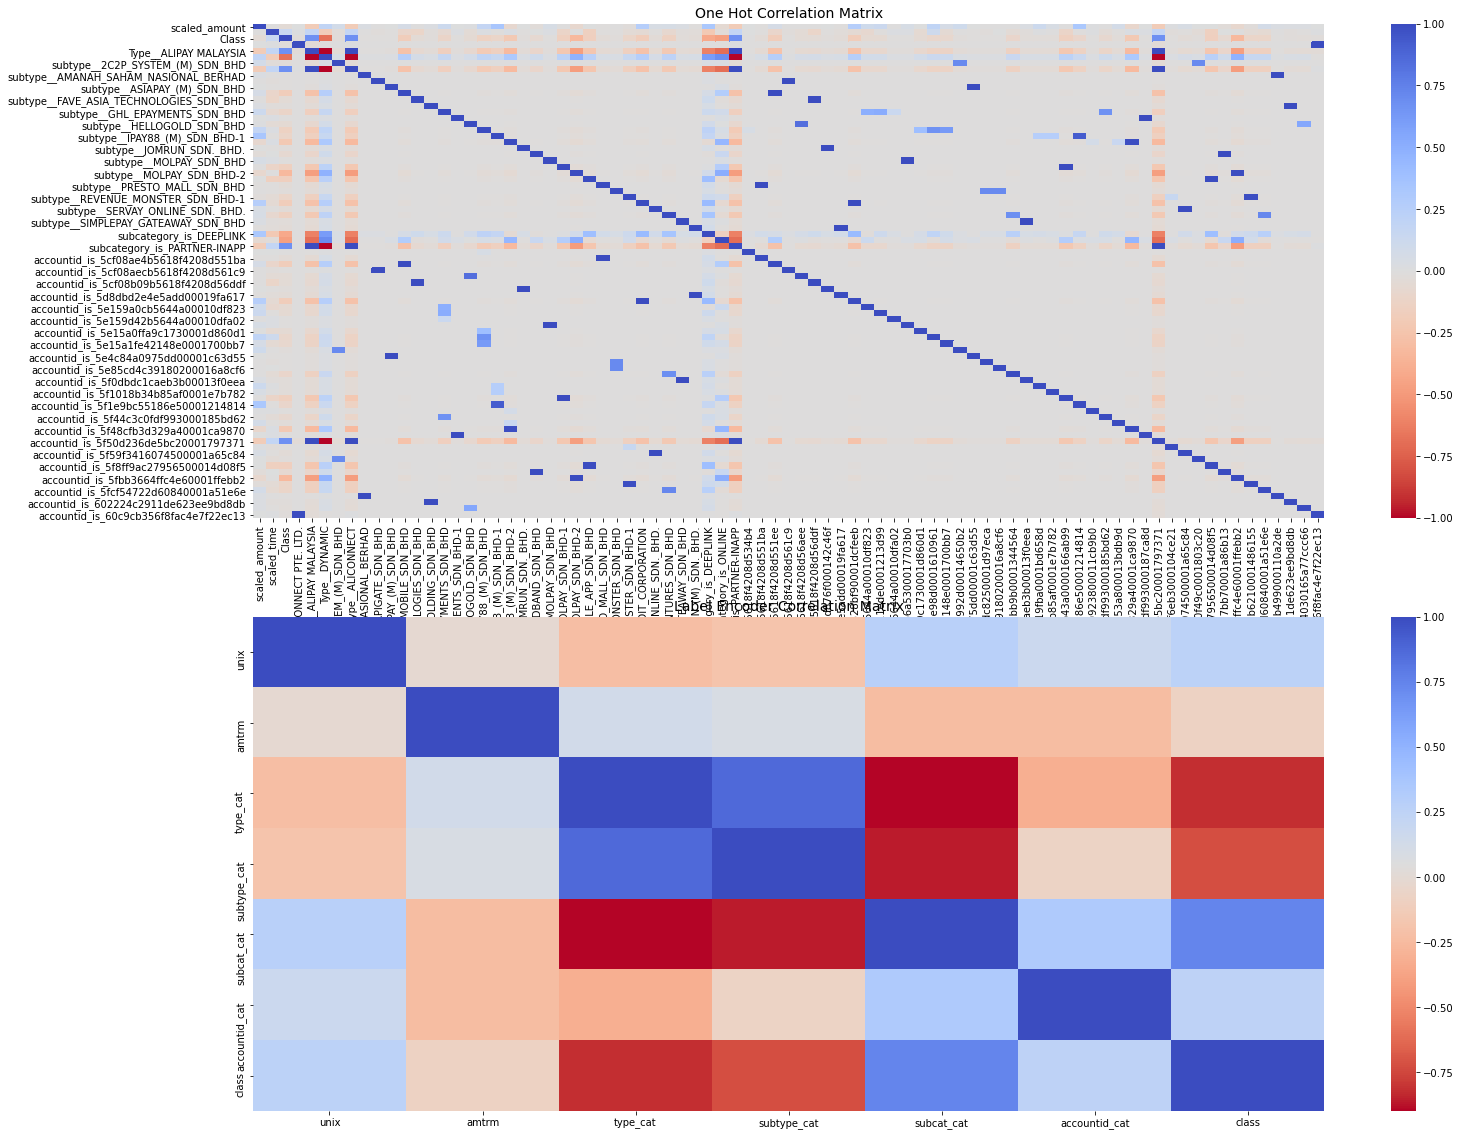

OH correlation 116.08283567428589
LE encoder 1.016083002090454


In [25]:
# Make sure we use the subsample in our correlation

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24,20))

# Entire DataFrame
t0 = time.time()
corr = enc_df.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title("One Hot Correlation Matrix", fontsize=14)
t2 = time.time()

le_corr = le_df.corr()
sns.heatmap(le_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax2)
ax2.set_title("Label Encoder Correlation Matrix", fontsize=14)
t3 = time.time()
plt.show()

print("OH correlation", t2-t0)
print("LE encoder", t3-t2)

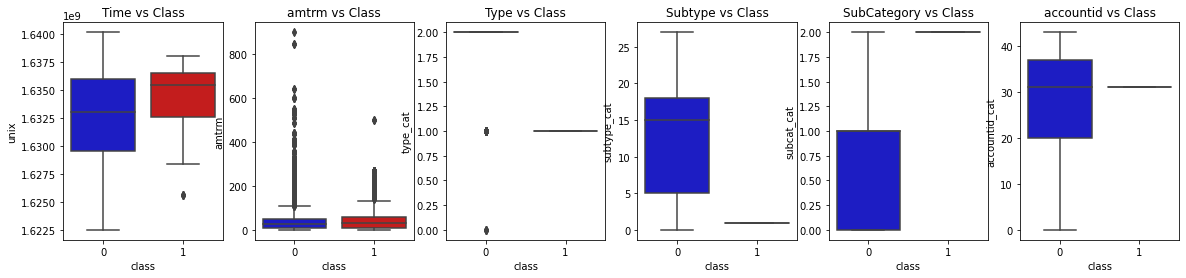

In [26]:
f, axes = plt.subplots(ncols=6, figsize=(20,4))

# Negative Correlations with our Class (The lower our feature value the more likely it will be a fraud transaction)
sns.boxplot(x="class", y="unix", data=le_df, palette=colors, ax=axes[0])
axes[0].set_title('Time vs Class')

sns.boxplot(x="class", y="amtrm", data=le_df, palette=colors, ax=axes[1])
axes[1].set_title('amtrm vs Class')

sns.boxplot(x="class", y="type_cat", data=le_df, palette=colors, ax=axes[2])
axes[2].set_title('Type vs Class')

sns.boxplot(x="class", y="subtype_cat", data=le_df, palette=colors, ax=axes[3])
axes[3].set_title('Subtype vs Class')

sns.boxplot(x="class", y="subcat_cat", data=le_df, palette=colors, ax=axes[4])
axes[4].set_title('SubCategory vs Class')

sns.boxplot(x="class", y="accountid_cat", data=le_df, palette=colors, ax=axes[5])
axes[5].set_title('accountid vs Class')

plt.show()

Above we can see the correlations

The **Label Encoded** version shows a better correlation with the categories.
The columns to take note of:
- time (unix)
- subcategory
- accountid

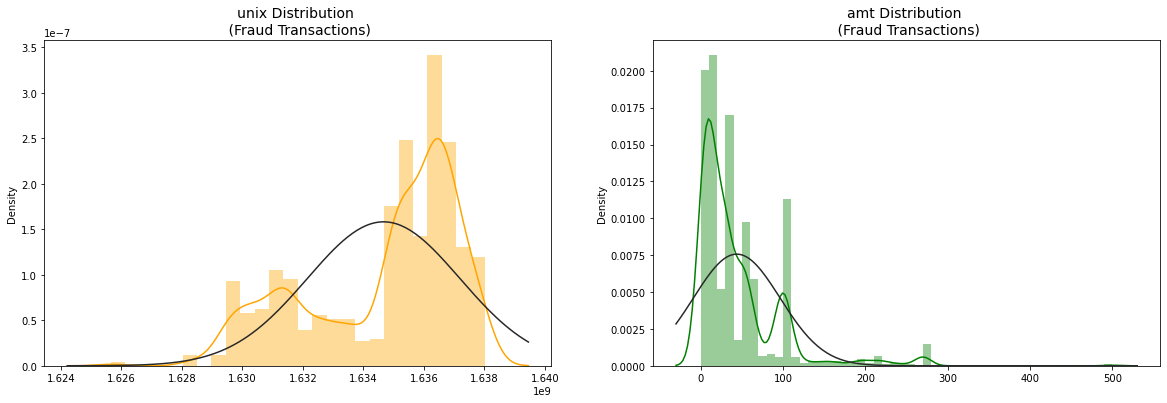

In [27]:
from scipy.stats import norm

f, (ax1, ax2) = plt.subplots(1,2, figsize=(20, 6))

time_fraud_dist = le_df['unix'].loc[le_df['class'] == 1].values
sns.distplot(time_fraud_dist,ax=ax1, fit=norm, color='orange')
ax1.set_title('unix Distribution \n (Fraud Transactions)', fontsize=14)

amt_fraud_dist = le_df['amtrm'].loc[le_df['class'] == 1].values
sns.distplot(amt_fraud_dist,ax=ax2, fit=norm, color='green')
ax2.set_title('amt Distribution \n (Fraud Transactions)', fontsize=14)

plt.show()

Seems to have somewhat expected distribution

Not really sure why I did this tbh

Note to self: freaking write down what you were thinking when you were executing it

In [28]:
# New_df is from the random undersample data (fewer instances)
X = le_df.drop('class', axis=1)
y = le_df['class']


# T-SNE Implementation
t0 = time.time()
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("T-SNE took {:.2} s".format(t1 - t0))

# PCA Implementation
t0 = time.time()
X_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("PCA took {:.2} s".format(t1 - t0))

# TruncatedSVD
t0 = time.time()
X_reduced_svd = TruncatedSVD(n_components=2, algorithm='randomized', random_state=42).fit_transform(X.values)
t1 = time.time()
print("Truncated SVD took {:.2} s".format(t1 - t0))

T-SNE took 5.9e+01 s
PCA took 0.075 s
Truncated SVD took 0.018 s


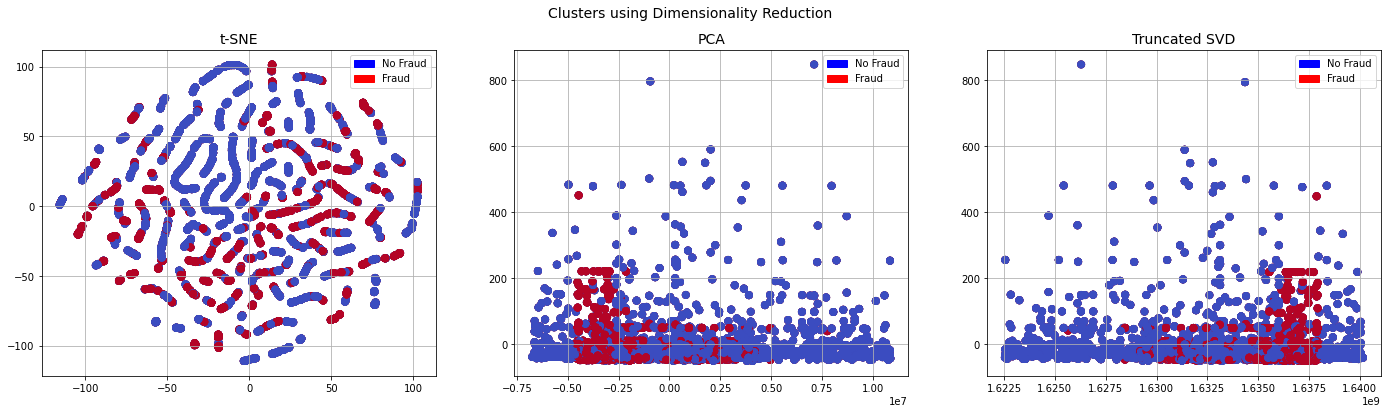

In [29]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,6))
# labels = ['No Fraud', 'Fraud']
f.suptitle('Clusters using Dimensionality Reduction', fontsize=14)


blue_patch = mpatches.Patch(color='blue', label='No Fraud')
red_patch = mpatches.Patch(color='red', label='Fraud')


# t-SNE scatter plot
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)

ax1.grid(True)

ax1.legend(handles=[blue_patch, red_patch])


# PCA scatter plot
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax2.set_title('PCA', fontsize=14)

ax2.grid(True)

ax2.legend(handles=[blue_patch, red_patch])

# TruncatedSVD scatter plot
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax3.set_title('Truncated SVD', fontsize=14)

ax3.grid(True)

ax3.legend(handles=[blue_patch, red_patch])

plt.show()

It seems like there's no point in using these, as there are no real clusters forming